In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from pycocotools.coco import COCO
import requests
import tarfile
import zipfile
from tqdm import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Download COCO 2017 dataset
!mkdir coco
!wget http://images.cocodataset.org/zips/train2017.zip -P coco/
!wget http://images.cocodataset.org/zips/val2017.zip -P coco/
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P coco/

# Extract files
!unzip coco/train2017.zip -d coco/
!unzip coco/val2017.zip -d coco/
!unzip coco/annotations_trainval2017.zip -d coco/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: coco/val2017/000000365745.jpg  
 extracting: coco/val2017/000000320425.jpg  
 extracting: coco/val2017/000000481404.jpg  
 extracting: coco/val2017/000000314294.jpg  
 extracting: coco/val2017/000000335328.jpg  
 extracting: coco/val2017/000000513688.jpg  
 extracting: coco/val2017/000000158548.jpg  
 extracting: coco/val2017/000000132116.jpg  
 extracting: coco/val2017/000000415238.jpg  
 extracting: coco/val2017/000000321333.jpg  
 extracting: coco/val2017/000000081738.jpg  
 extracting: coco/val2017/000000577584.jpg  
 extracting: coco/val2017/000000346905.jpg  
 extracting: coco/val2017/000000433980.jpg  
 extracting: coco/val2017/000000228144.jpg  
 extracting: coco/val2017/000000041872.jpg  
 extracting: coco/val2017/000000117492.jpg  
 extracting: coco/val2017/000000368900.jpg  
 extracting: coco/val2017/000000376900.jpg  
 extracting: coco/val2017/000000352491.jpg  
 extracting: coco/val2

In [3]:
# Set paths
train_img_dir = '/content/coco/train2017'
val_img_dir = '/content/coco/val2017'
train_ann_file = '/content/coco/annotations/captions_train2017.json'
val_ann_file = '/content/coco/annotations/captions_val2017.json'

In [4]:
from nltk.tokenize import word_tokenize
from collections import Counter

# Vocabulary Class
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, coco):
        counter = Counter()
        ids = coco.anns.keys()
        for idx in ids:
            caption = str(coco.anns[idx]['caption']).lower()
            tokens = word_tokenize(caption)
            counter.update(tokens)

        idx = 4
        for word, cnt in counter.items():
            if cnt >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = word_tokenize(text.lower())
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


In [5]:
from pycocotools.coco import COCO
from PIL import Image
import os
from torch.utils.data import Dataset

# Dataset Class
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.coco)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        img_path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root_dir, img_path)).convert("RGB")
        if self.transform:
            image = self.transform(image)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        return image, torch.tensor(numericalized_caption)


In [6]:
from torchvision import transforms
import random
import torch
import nltk
nltk.download('punkt_tab')

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Higher resolution for better features
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load Dataset and Reduce Size
train_img_dir = '/content/coco/train2017'
train_ann_file = '/content/coco/annotations/captions_train2017.json'
train_dataset = CocoDataset(train_img_dir, train_ann_file, transform=transform)

# Reduce dataset size for quicker training
reduced_size = 10000
indices = random.sample(range(len(train_dataset)), reduced_size)
train_dataset_reduced = torch.utils.data.Subset(train_dataset, indices)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


loading annotations into memory...
Done (t=0.97s)
creating index...
index created!


In [7]:
from torch.utils.data import DataLoader

# DataLoader with Collate Function
def collate_fn(batch):
    images = [item[0].unsqueeze(0) for item in batch]
    images = torch.cat(images, dim=0)
    captions = [item[1] for item in batch]
    lengths = [len(cap) for cap in captions]

    padded_captions = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]

    return images, padded_captions, lengths

batch_size = 16
train_loader = DataLoader(
    train_dataset_reduced,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)


In [8]:
import torch.nn as nn
from torchvision import models
from torch.nn.utils.rnn import pack_padded_sequence

# Encoder
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        features = self.resnet(x)
        features = features.view(features.size(0), -1)
        features = self.dropout(self.embed(features))
        return features

# Decoder
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs.data)
        return outputs

# Combined Model
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs


In [9]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 128
hidden_size = 512
num_layers = 3
learning_rate = 1e-4
num_epochs = 25

vocab_size = len(train_dataset.vocab.itos)
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


In [10]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, captions, lengths in tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        captions_input = captions[:, :-1]  # Exclude <EOS> from input
        captions_target = captions[:, 1:]  # Exclude <SOS> from target
        lengths = [l - 1 for l in lengths]

        # Forward pass
        outputs = model(images, captions_input, lengths)

        # Pack targets to match outputs
        targets = pack_padded_sequence(captions_target, lengths, batch_first=True, enforce_sorted=False).data

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


100%|██████████| 625/625 [03:22<00:00,  3.08it/s]


Epoch [1/25], Loss: 5.4128


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [2/25], Loss: 4.9109


100%|██████████| 625/625 [02:59<00:00,  3.49it/s]


Epoch [3/25], Loss: 4.8193


100%|██████████| 625/625 [02:59<00:00,  3.49it/s]


Epoch [4/25], Loss: 4.7048


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [5/25], Loss: 4.6382


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [6/25], Loss: 4.5900


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [7/25], Loss: 4.5470


100%|██████████| 625/625 [02:58<00:00,  3.50it/s]


Epoch [8/25], Loss: 4.5265


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [9/25], Loss: 4.5066


100%|██████████| 625/625 [03:00<00:00,  3.45it/s]


Epoch [10/25], Loss: 4.4861


100%|██████████| 625/625 [03:00<00:00,  3.46it/s]


Epoch [11/25], Loss: 4.4744


100%|██████████| 625/625 [03:00<00:00,  3.45it/s]


Epoch [12/25], Loss: 4.4610


100%|██████████| 625/625 [03:01<00:00,  3.45it/s]


Epoch [13/25], Loss: 4.4445


100%|██████████| 625/625 [02:59<00:00,  3.49it/s]


Epoch [14/25], Loss: 4.4362


100%|██████████| 625/625 [02:59<00:00,  3.48it/s]


Epoch [15/25], Loss: 4.4274


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [16/25], Loss: 4.4176


100%|██████████| 625/625 [02:59<00:00,  3.48it/s]


Epoch [17/25], Loss: 4.4133


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [18/25], Loss: 4.4096


100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Epoch [19/25], Loss: 4.4043


100%|██████████| 625/625 [03:00<00:00,  3.46it/s]


Epoch [20/25], Loss: 4.4025


100%|██████████| 625/625 [02:59<00:00,  3.49it/s]


Epoch [21/25], Loss: 4.3993


100%|██████████| 625/625 [03:00<00:00,  3.46it/s]


Epoch [22/25], Loss: 4.3964


100%|██████████| 625/625 [03:00<00:00,  3.46it/s]


Epoch [23/25], Loss: 4.3962


100%|██████████| 625/625 [03:01<00:00,  3.45it/s]


Epoch [24/25], Loss: 4.3939


100%|██████████| 625/625 [03:01<00:00,  3.45it/s]

Epoch [25/25], Loss: 4.3933


In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# Preprocess Test Image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Match training size
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension


In [12]:
def generate_caption(model, image, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        # Extract features using the encoder
        features = model.encoder(image.to(device))

        # Start with the <SOS> token
        caption = [vocab.stoi["<SOS>"]]
        for _ in range(max_length):
            caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)  # Add batch dimension
            outputs = model.decoder(features, caption_tensor, [len(caption)])

            # Get the most probable word
            _, predicted = outputs[-1].max(0)  # Get the prediction for the last word
            next_word = predicted.item()
            caption.append(next_word)

            # Stop if <EOS> is generated
            if next_word == vocab.stoi["<EOS>"]:
                break

    # Convert indices to words
    caption_text = " ".join([vocab.itos[idx] for idx in caption[1:-1]])  # Remove <SOS> and <EOS>
    return caption_text


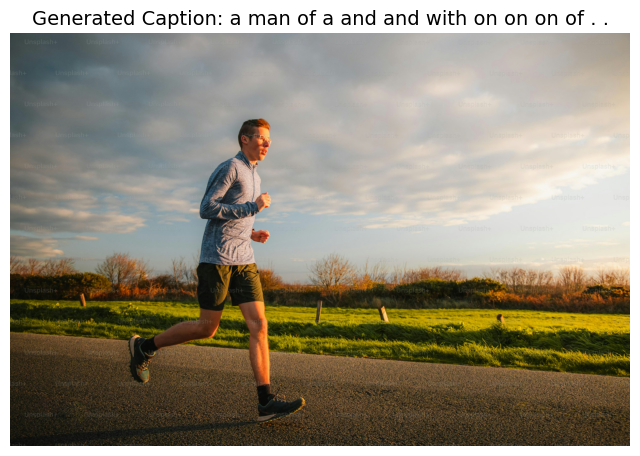

In [14]:
# Test the model with a sample image
test_image_path = "/content/premium_photo-1669021454145-49146869b916.jpg"  # Replace with the path to your test image
test_image = preprocess_image(test_image_path).to(device)

# Generate the caption
generated_caption = generate_caption(model, test_image, train_dataset.vocab)

# Display the image and caption
plt.figure(figsize=(8, 8))
image = Image.open(test_image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Generated Caption: {generated_caption}", fontsize=14)
plt.show()
